In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

import time
import random

import cv2
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from PIL import Image
from pathlib import Path

from sklearn.metrics import confusion_matrix

from glob import glob

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load full data

In [3]:
image_path = "/kaggle/input/cat-and-dog"

Text(0.5, 1.0, 'Image class: cats')

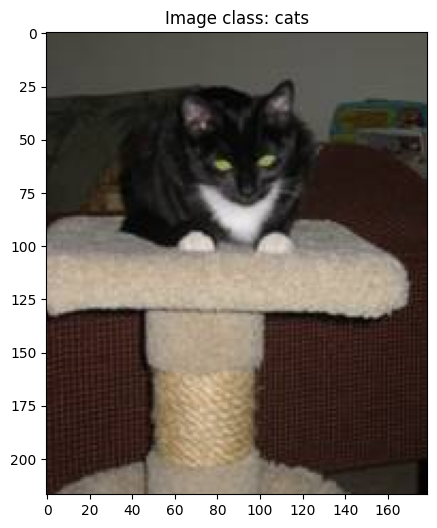

In [4]:
# Set seed
random.seed(42) 

# Lấy tất cả ảnh từ cả 2 bộ train, test
image_path_list= glob(f"{image_path}/*/*/*/*.jpg")

# Lấy 1 ảnh random
random_image_path = random.choice(image_path_list)
image_class = Path(random_image_path).parent.stem
img = Image.open(random_image_path)

# Vẽ ảnh
img_as_array = np.asarray(img)
plt.figure(figsize=(8, 6))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class}")

## Thử chuẩn hóa data với transform

In [5]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to IMAGE_SIZE xIMAGE_SIZE 
    transforms.Resize(size=IMAGE_SIZE),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

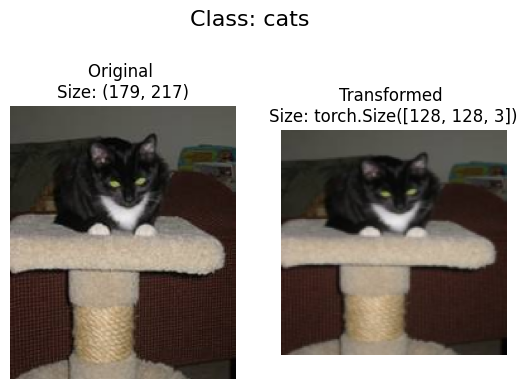

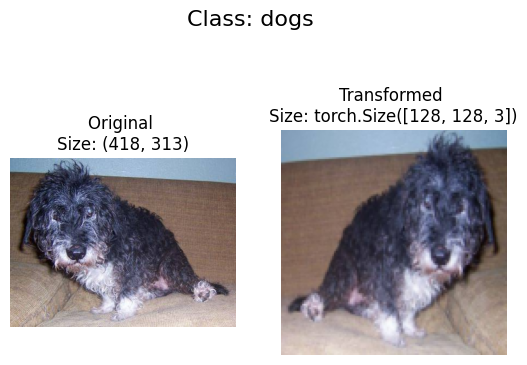

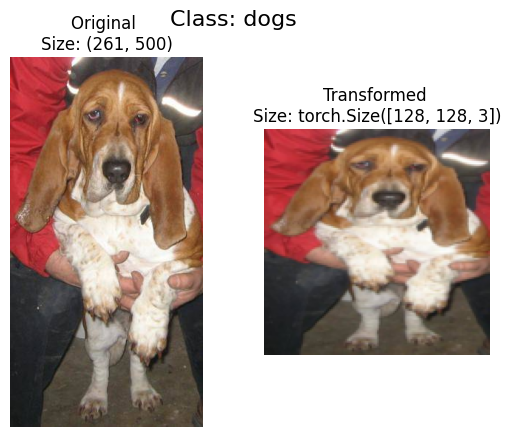

In [6]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {Path(image_path).parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform, n=3)

## Load train, test data

In [7]:
train_dir = "/kaggle/input/cat-and-dog/training_set/training_set"
test_dir = "/kaggle/input/cat-and-dog/test_set/test_set"

In [8]:
# Creating training set
train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=data_transform, 
                                  target_transform=None) 
#Creating test set
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)


Các nhãn:  ['cats', 'dogs']
Số lượng bộ data train và test:  8005 2023
Image tensor:
tensor([[[0.1569, 0.1608, 0.1608,  ..., 0.6196, 0.7765, 0.7882],
         [0.1529, 0.1490, 0.1490,  ..., 0.6118, 0.7529, 0.7882],
         [0.1490, 0.1333, 0.1333,  ..., 0.6118, 0.7373, 0.7882],
         ...,
         [0.0863, 0.0784, 0.0784,  ..., 0.2392, 0.2627, 0.1725],
         [0.1098, 0.0902, 0.0863,  ..., 0.2196, 0.1804, 0.1725],
         [0.1176, 0.0902, 0.0863,  ..., 0.2431, 0.1804, 0.1765]],

        [[0.1765, 0.1765, 0.1725,  ..., 0.6235, 0.7686, 0.7725],
         [0.1725, 0.1647, 0.1608,  ..., 0.6118, 0.7373, 0.7686],
         [0.1686, 0.1490, 0.1451,  ..., 0.6039, 0.7137, 0.7608],
         ...,
         [0.0784, 0.0706, 0.0706,  ..., 0.1725, 0.2078, 0.1255],
         [0.1020, 0.0824, 0.0784,  ..., 0.1569, 0.1255, 0.1255],
         [0.1098, 0.0824, 0.0784,  ..., 0.1804, 0.1255, 0.1373]],

        [[0.1608, 0.1765, 0.1922,  ..., 0.5843, 0.6706, 0.6431],
         [0.1569, 0.1647, 0.1804,  ...

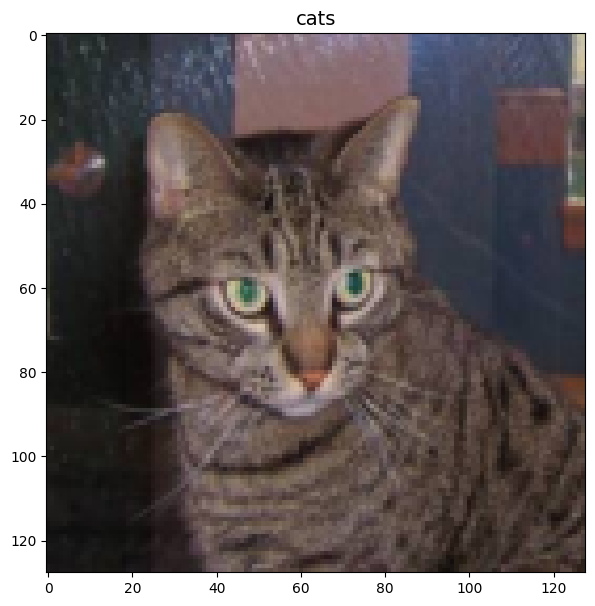

In [9]:
# Get class names as a list
class_names = train_data.classes
print("Các nhãn: ",class_names)

# Check the lengths
print("Số lượng bộ data train và test: ", len(train_data), len(test_data))

img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Kiểu dữ liệu của ảnh: {img.dtype}")
print(f"Nhãn: {label}")
print(f"Kiểu dữ liệu của nhãn: {type(label)}")

# Thay đổi lại thứ tự chiều
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label], fontsize=14);

### Chuyển bộ dữ liệu sang DataLoader

In [10]:
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, 
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             shuffle=False)

In [11]:
img, label = next(iter(train_dataloader))

# Note that batch size will now be 1.  
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 128, 128]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## Xây dựng mô hình với tăng cường dữ liệu

### Tăng cường dữ liệu: Làm đa dạng thông tin của dữ liệu mà vẫn nhận diện được nhãn

In [12]:
# Set image size.
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Create training transform with TrivialAugment
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()])

In [13]:
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
test_data_augmented = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_augmented

(Dataset ImageFolder
     Number of datapoints: 8005
     Root location: /kaggle/input/cat-and-dog/training_set/training_set
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 2023
     Root location: /kaggle/input/cat-and-dog/test_set/test_set
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [14]:
BATCH_SIZE = 32
torch.manual_seed(42)

train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True)

test_dataloader_augmented = DataLoader(test_data_augmented, 
                                       batch_size=BATCH_SIZE, 
                                       shuffle=False)
                                       

train_dataloader_augmented, test_dataloader_augmented

(<torch.utils.data.dataloader.DataLoader at 0x7b3dfc4057b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b3dfc2576d0>)

### Xây mô hình CNN

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
          nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(num_features = 64),
          nn.MaxPool2d(kernel_size = 2))
        self.conv_layer_2 = nn.Sequential(
          nn.Conv2d(in_channels = 64, out_channels = 512, kernel_size = 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(num_features = 512),
          nn.MaxPool2d(2))
        self.conv_layer_3 = nn.Sequential(
          nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(num_features = 512),
          nn.MaxPool2d(2)) 
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=512*3*3, out_features=2))
    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.classifier(x)
        return x
# Instantiate an object.
model = CNN()

if torch.cuda.is_available():
    model.cuda()

### Thử dự đoán với mô hình này

In [16]:
img_batch, label_batch = next(iter(train_dataloader_augmented))

img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))
    
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 224, 224])

Output logits:
tensor([[-0.0115, -0.0106]], device='cuda:0')

Output prediction probabilities:
tensor([[0.4998, 0.5002]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
1


### Xem cấu trúc mô hình 

In [17]:
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
# do a test pass through of an example input size 
summary(model, input_size=[1, 3, IMAGE_WIDTH ,IMAGE_HEIGHT]) 

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─BatchNorm2d: 2-3                  [1, 64, 224, 224]         128
│    └─MaxPool2d: 2-4                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 512, 56, 56]          --
│    └─Conv2d: 2-5                       [1, 512, 112, 112]        295,424
│    └─ReLU: 2-6                         [1, 512, 112, 112]        --
│    └─BatchNorm2d: 2-7                  [1, 512, 112, 112]        1,024
│    └─MaxPool2d: 2-8                    [1, 512, 56, 56]          --
├─Sequential: 1-3                        [1, 512, 28, 28]          --
│    └─Conv2d: 2-9                       [1, 512, 56, 56]          2,359,

## Tạo hàm train_step và test_step

In [18]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [19]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## Tạo hàm để train model

In [20]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in (range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


## Train và đánh giá mô hình

In [21]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 25

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

# Train model_0 
model_results = train(model=model,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_augmented,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)

Epoch: 1 | train_loss: 0.9636 | train_acc: 0.5553 | test_loss: 0.8265 | test_acc: 0.5268
Epoch: 2 | train_loss: 0.8497 | train_acc: 0.6028 | test_loss: 0.8385 | test_acc: 0.6038
Epoch: 3 | train_loss: 0.7568 | train_acc: 0.6317 | test_loss: 0.7251 | test_acc: 0.6696
Epoch: 4 | train_loss: 0.7518 | train_acc: 0.6372 | test_loss: 0.9274 | test_acc: 0.6493
Epoch: 5 | train_loss: 0.7285 | train_acc: 0.6629 | test_loss: 0.7652 | test_acc: 0.6578
Epoch: 6 | train_loss: 0.6412 | train_acc: 0.6943 | test_loss: 0.9919 | test_acc: 0.6520
Epoch: 7 | train_loss: 0.6359 | train_acc: 0.7066 | test_loss: 0.5819 | test_acc: 0.7047
Epoch: 8 | train_loss: 0.5384 | train_acc: 0.7352 | test_loss: 0.4803 | test_acc: 0.7687
Epoch: 9 | train_loss: 0.4915 | train_acc: 0.7641 | test_loss: 0.5060 | test_acc: 0.7612
Epoch: 10 | train_loss: 0.4626 | train_acc: 0.7839 | test_loss: 0.4717 | test_acc: 0.7616
Epoch: 11 | train_loss: 0.4163 | train_acc: 0.8054 | test_loss: 0.4474 | test_acc: 0.7836
Epoch: 12 | train_l

In [22]:
# Trực quan hóa độ mất mát và chính xác của mô hình
def plot_loss_curves(results):
  
    results = dict(list(model_results.items()))

    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

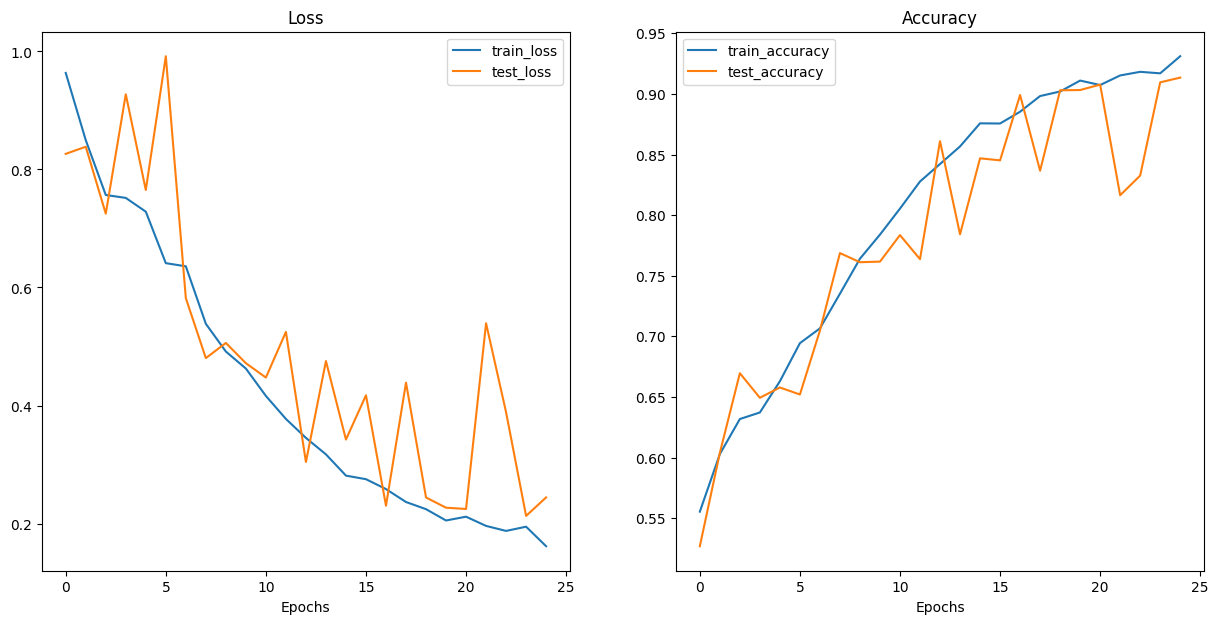

In [23]:
plot_loss_curves(model_results)

## Thử dự đoán với dữ liệu mới

In [24]:
custom_image_path = "/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4200.jpg"

import torchvision
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Đưa pixel về khoảng [0,1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.5922, 0.7216, 0.7725,  ..., 0.6549, 0.6431, 0.6275],
         [0.5804, 0.6824, 0.7216,  ..., 0.5922, 0.6275, 0.6157],
         [0.6118, 0.6745, 0.6980,  ..., 0.6510, 0.5765, 0.5608],
         ...,
         [0.5843, 0.4902, 0.4784,  ..., 0.6667, 0.7294, 0.7216],
         [0.5451, 0.4627, 0.4745,  ..., 0.6745, 0.6902, 0.6863],
         [0.5255, 0.4549, 0.4745,  ..., 0.6667, 0.6314, 0.6235]],

        [[0.6706, 0.8000, 0.8510,  ..., 0.6941, 0.6863, 0.6745],
         [0.6510, 0.7569, 0.7961,  ..., 0.6314, 0.6706, 0.6627],
         [0.6745, 0.7373, 0.7647,  ..., 0.6902, 0.6196, 0.6118],
         ...,
         [0.6431, 0.5451, 0.5176,  ..., 0.6510, 0.7255, 0.7216],
         [0.6275, 0.5412, 0.5176,  ..., 0.6706, 0.6863, 0.6863],
         [0.6078, 0.5333, 0.5176,  ..., 0.6627, 0.6275, 0.6235]],

        [[0.5647, 0.6902, 0.7412,  ..., 0.6627, 0.6196, 0.5804],
         [0.5490, 0.6471, 0.6784,  ..., 0.6000, 0.6039, 0.5765],
         [0.5686, 0.6314, 0.6392,  ..

In [25]:
custom_image_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
])

custom_image_transformed = custom_image_transform(custom_image)

print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 499, 434])
New shape: torch.Size([3, 224, 224])


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [26]:
model.eval()
with torch.no_grad():
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    custom_image_pred = model(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 224, 224])
Unsqueezed custom image shape: torch.Size([1, 3, 224, 224])


In [27]:
custom_image_pred

tensor([[-6.5131,  6.7262]], device='cuda:0')

In [29]:
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction probabilities: tensor([[1.7792e-06, 1.0000e+00]], device='cuda:0')
Prediction label: tensor([1], device='cuda:0')


In [30]:
custom_image_pred_class = class_names[custom_image_pred_label.cuda()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'dogs'

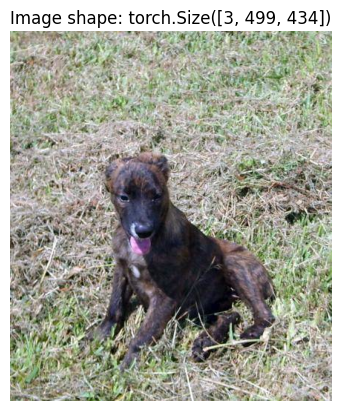

In [31]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

# Save model

In [32]:
torch.save(model, "cat-dog.pth")